# AirBnB Seattle

This notebook is written from the perspective of someone wanting to visit Seattle and tries to answer the following questions:

1) Where are most of the accommodations located?

2) What do accommodations tend to cost?

3) Where should I stay if I'm on a budget or what to get the best value for my money? And where not?

# Data Preparation

This section reads in the necessary libraries, data, and transforms the data so that it can be analysed in the next section.

## Libraries and data

In [1]:
# Read in the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
pd.options.display.max_rows = 999 # listings has a lot of columns; this way you can see all of them

In [2]:
# Read in the datasets
calendar = pd.read_csv('C:/.../calendar.csv')
listings = pd.read_csv('C:/.../listings.csv')
reviews = pd.read_csv('C:/.../reviews.csv')

## Data Transformations

In [3]:
# transform price to a float
listings['price'] = listings['price'].apply(lambda x: x.strip('$')) # deletes '$'
listings['price'] = listings['price'].apply(lambda x: x.replace(',', '')) # deletes ','
listings['price'] = listings['price'].astype('float') # changes type

In [4]:
# calculate price per person
listings['price_per_person'] = listings['price'] / listings['accommodates']

# first transformation of only the necessary data
df_locations_prices = listings.groupby(['latitude', 'longitude'])[['price_per_person', 'review_scores_rating', 'review_scores_value']].mean().reset_index() 
df_locations_prices.head()

# get the average price per person, review, value per lat/long rounded to two decimals
df_locations_rounded = df_locations_prices.apply(lambda x: round(x, 2)) # round lat/long
df_locations_prices_rounded = df_locations_rounded.groupby(['latitude', 'longitude'])['price_per_person'].mean().reset_index() # get average price per person per lat/long
df_locations_review_rounded = df_locations_rounded.groupby(['latitude', 'longitude'])['review_scores_rating'].mean().reset_index() # get average rating per lat/long
df_locations_value_rounded = df_locations_rounded.groupby(['latitude', 'longitude'])['review_scores_value'].mean().reset_index() # get value rating per lat/long

# function to reshape data so that it can be plotted as heatmap
def reshape_heatmap(df, lat, long, field):
    df_pivot = df.pivot_table(index=lat, columns=long, values=field) # reshape so that it can be plotted as a map
    cols = df_pivot.columns.tolist() # get list of columns
    cols.sort() # sort the columns
    df_pivot = df_pivot[cols] # sort the columns in the df
    df_pivot = df_pivot.sort_index(ascending=False) # sort the rows
    
    return df_pivot

# reshape the final data
df_locations_prices_rounded_pivot = reshape_heatmap(df_locations_prices_rounded, 'latitude', 'longitude', 'price_per_person')
df_locations_review_rounded_pivot = reshape_heatmap(df_locations_review_rounded, 'latitude', 'longitude', 'review_scores_rating')
df_locations_value_rounded_pivot = reshape_heatmap(df_locations_value_rounded, 'latitude', 'longitude', 'review_scores_value')

# Where are the accommodations located?

The majority of properties are located near Lake Union, particularly in Bell Town and Capitol Hill.

## Plot using Folium with an actual map

In [5]:
# Plots the map relevant to the available lat/long
m = folium.Map([df_locations_prices.latitude.mean(), df_locations_prices.longitude.mean()], zoom_start=11)

# Add each lat/long of each accommodation onto the map
for index, row in df_locations_prices.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=1,       
                        fill_color="#3db7e4",               
                        opacity=0.3
                       ).add_to(m)
    
# plot the map
m

## Plotting using a distplot

You can see a similar story using a distplot and clearly see the concentration of properties in downtown and a bit further north west (Freemont).

C:\Users\Alessandro\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


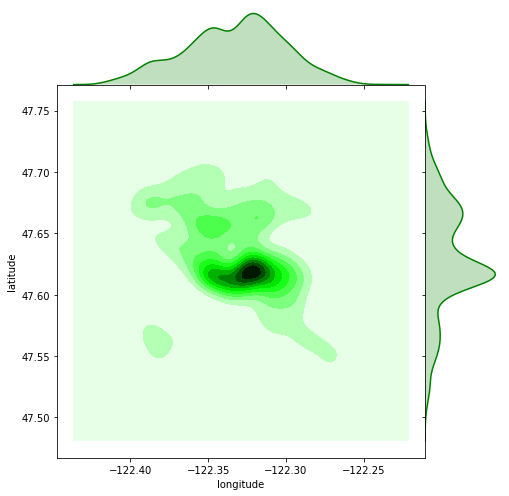

In [6]:
# plot jointplot
sns.jointplot("longitude", "latitude", data=listings,
                  kind="kde", space=0, color="g", height=7);

# Cost of accommodation

Three quarters of the listed properties cost between 20 USD and 150 USD and on average 100 USD (median). There are a few properties that are much more expensive and the price can go up to 1000 USD.

On a person basis, three quarters of properties would cost between 27.50 USD and 50 USD, with an average cost of 47.50 USD (median). Costs can go up to 275 USD. 

## Cost of entire accomodation

In [7]:
# get basic desxriptive stats of price
listings['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

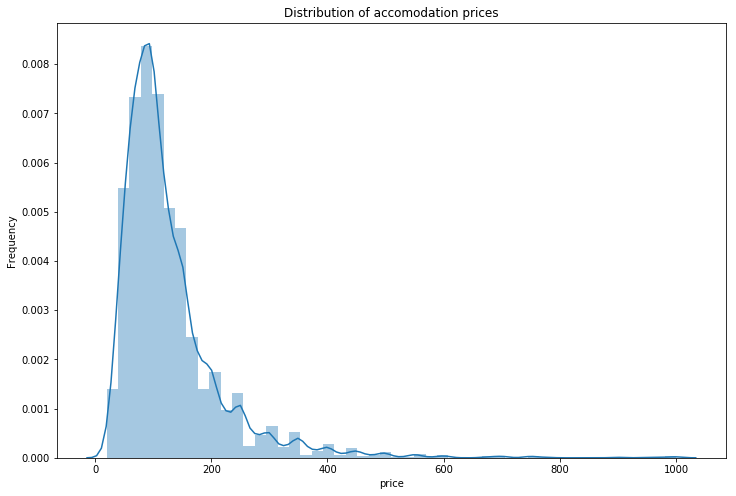

In [8]:
plt.figure(figsize=(12,8)) # set size of the plot
sns.distplot(listings['price']) # plot distribution of price
plt.title('Distribution of accomodation prices') # write title
plt.ylabel('Frequency'); # write label of y-axis

## Distribution cost per person

In [9]:
# get basic descriptive stats
listings['price_per_person'].describe() 

count    3818.000000
mean       41.266923
std        20.676221
min         4.750000
25%        27.500000
50%        37.500000
75%        50.000000
max       275.000000
Name: price_per_person, dtype: float64

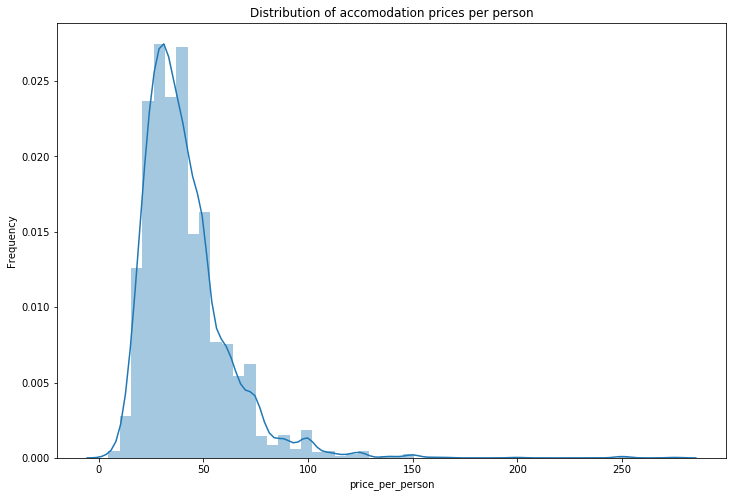

In [10]:
plt.figure(figsize=(12,8)) # set size of the plot
sns.distplot(listings['price_per_person']) # plot distribution of price
plt.title('Distribution of accomodation prices per person') # write title
plt.ylabel('Frequency'); # write label of y-axis

# Where should you stay?

1) Downtown, unsurprisingly, has the most expensive accomodations, even accounting for how many people could stay in the accomodation. 

2) In West Seattle (South West corner) accomodations also tend to be more expensive towards the water and further away from the airport. 

3) Review scores tend to be relatively uniform with the exception of University District and Maple Leaf where they are  worse.

4) Value scores tell a similar story. Downtown does also a bit worse as the cost is much higher than elsewhere.

To conclude, if you are on a budget, stay away from downtown. Even though University District and Maple Leaf are much cheaper, they also tend to not be good value for money or get very good reviews.

You are probably best off staying somewhere in the North West if price matters to you.

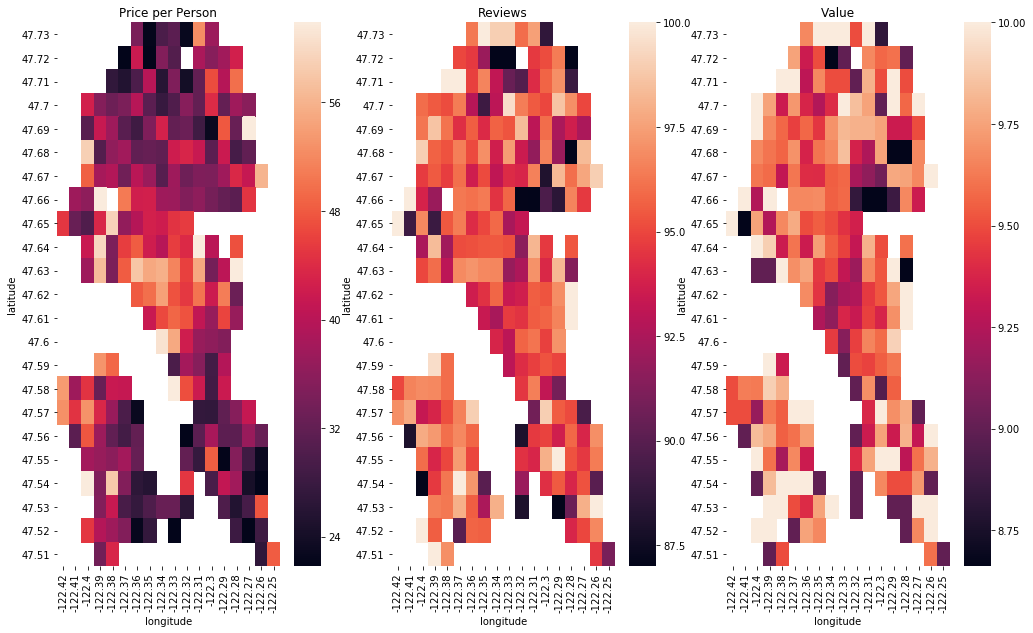

In [11]:
# plot size
plt.figure(figsize=(17,10))

# plot 1
ax1 = plt.subplot(1,3,1)
sns.heatmap(df_locations_prices_rounded_pivot, robust=True, cbar=True)
plt.title('Price per Person')

# plot 2
ax2 = plt.subplot(1,3,2,sharex=ax1)
sns.heatmap(df_locations_review_rounded_pivot, robust=True, cbar=True)
plt.title('Reviews')

# plot 3
ax3 = plt.subplot(1,3,3,sharex=ax1)
sns.heatmap(df_locations_value_rounded_pivot, robust=True, cbar=True)
plt.title('Value');